Здравствуйте!

У меня задание 3

Задача 1.3.7:

$y'(t)=y(y(t)) + (3 + \alpha)t^{(2 + \alpha)} -t^{{(3 + \alpha)}^2}$

$y(0) = 0$

Аналитическое решение: $y(t) = t^{(3 + \alpha)}, \qquad 0 \leq t \leq 1$

При возникновении перекрытия я приближаю решение значением в начале совершаемого шага.

Вкратце про формат: это IPython notebook, язык python3. Почему он? Родней просто. Чем отличается от matlab? Честно говоря, не знаю, но вряд ли чем-то значимым. Умножается/делится/складывается всё так же.

In [1]:
y0 = 0
delay = lambda t: t
alpha = 2
f = lambda t, y, delayed_y: delayed_y[0] + (3 + alpha) * t ** (2 + alpha) - t ** ((3 + alpha) ** 2)
get_true_fun = lambda t: t ** (alpha + 3)
n = 9

def get_delayed_y(t, history_funs, curr_y, get_overlap_value, h, k, tn, curr_y_at_start):
    delayed_y = get_y(curr_y[0], history_funs, curr_y, get_overlap_value, t, h, k, tn, curr_y_at_start)
    return delayed_y

In [2]:
def heun_schema():
    b = lambda t: [(t - (3 / 2) * (t ** 2) + (2 / 3) * (t ** 3)),
                   (0),
                   (2 * (t ** 2) - (4 / 3) * (t ** 3)),
                   (-(1 / 2) * (t ** 2) + (2 / 3) * (t ** 3))]
    c = [(1), (1 / 2), (1)]
    a = lambda t1, t2, t3 : [[(t1)],
                    [(t2 - 1 / 2 * (t2 ** 2)), (1 / 2 * (t2 ** 2))],
                    [(t3 - 1 / 2 * (t3 ** 2)), (1 / 2 * (t3 ** 2)), 0]]
    return a, b, c

Наверху код вроде понятен, lambda x, y, z, ... : "тело функции" -- это краткий способ задать функцию. x, y, z -- переменные, тело функции -- некоторое одно выражение. y и delayed_y изначально считают векторами, t - скаляр. И да, heun_schema() -- функция, возвращающая две другие функции и вектор, так можно.

Ниже функция для поиска истории, delayed_t -- запоздавшее время, curr_y -- значение в начале совершаемого шага, которым я приближаю по дефолту, previous_funs -- вектор из кортежей ($t_i$, $t_{i+1}$, $\eta_i$), где $t_i$ и $t_{i+1}$ -- начало и конец промежутка, $\eta_i$ -- интерполянт на данном промежутке, принимающий значение от 0 до 1.

Соответственно, для запоздавшего t мы бегаем по всей предыстории, ищем отрезок, которому он принадлежит, определяем, в какую часть его он попадает по $\frac{t - t_i}{t_{i+1}- t_{i}}$ и получаем нужное значение. Если оно не найдено, возвращаем curr_y.

In [3]:
def get_y(delayed_t, previous_funs, curr_y, get_overlap_value, curr_t, h, k, tn, curr_y_at_start):
    for (t_left, t_right, previous_fun) in previous_funs:
        if ((t_left <= delayed_t) and (delayed_t <= t_right)):
            theta = (delayed_t - t_left) / (t_right - t_left)
            return previous_fun(theta)
    ov = get_overlap_value(curr_y, delayed_t, h, tn, k, curr_y_at_start)
    return ov

Вот здесь нужно уточнение. Когда мы считаем $k_i$ и вызываем $f(t)$ (которая $y'(t)$), то в качестве запоздалых y мы отдаем ей $\eta(delay(t + c_i h)$, верно? то есть делаем шаг $t + c_i h$, ищем запаздывание от него и берем соответствующее ему значение предыстории и подставляем в $f()$?

Ну а так, t0 -- t на этом шаге, var_list -- y на этом шаге, fun_list -- список функций, delayed_var_list -- запоздавшие y в запоздашем t0, h -- шаг, get_schema -- heun_schema, например, history_funs - то же, что и раньше.
В $f()$ отдается t0, потому что запаздывание она считает сама. Считаем все $k$ на основе t0, var_list, c и a и возвращаем $k$ и $b$.

In [4]:
def get(t0, var_list, fun_list, delayed_var_list, h, get_schema, history_funs, get_overlap_value):
    schema = get_schema()
    a, b, c = schema()
    interp_a = a
    a = a(*c)
    k = []
    for fun in fun_list:
        k.append([fun(t0, var_list, delayed_var_list)])
    for ci, si in zip(c, range(0, len(c))):
        y_sum = []
        for one_k in k:
            y_sum.append(sum([ai * ki for ai, ki in zip(a[si], one_k)]))
        new_var_list = [y + h * y_s for y, y_s in zip(var_list, y_sum)]
        t_ = t0 + ci * h
        interpolated_a = interp_a(ci, ci, ci)
        y_sum_interp = []
        for one_k in k:
            y_sum_interp.append(sum([ai * ki for ai, ki in zip(interpolated_a[si], one_k)]))
        y_interp = [y + h * y_s for y, y_s in zip(var_list, y_sum_interp)]
        new_delay_var_list = get_delayed_y(t_, history_funs, new_var_list, get_overlap_value, h, k, t0, var_list)
        for fun, i in zip(fun_list, range(0, len(k))):
            k_next = fun(t_, new_var_list, new_delay_var_list)
            k[i].append(k_next)
    return b, k

Тут, наверно, единственное, что вызывает недоумение, это lambda в lambda, но это причуда компилятора питона:)

Ну и ещё мы фиксируем все переменные h, y, t0, чтобы new_var_list (следующий y) была функцией только от $\theta \in [0;1]$

In [5]:
def RK(t0, var_list, fun_list, delayed_var_list, h, get_schema, history_funs, get_overlap_value):
    b, k = get(t0, var_list, fun_list, delayed_var_list, h, get_schema, history_funs, get_overlap_value)
    print('k на этом шаге: {0}'.format(k))
    new_var_list = (lambda h, b, k, var_list:
                    (lambda t: [y + h * sum([bi * ki for bi, ki in zip(b(t), one_k)])
                                for y, one_k in zip(var_list, k)]) )(h, b, k, var_list)
    return new_var_list


In [6]:
get_schema = lambda : heun_schema

Пытаюсь построить решение с $2^k$ шагами. Потом по $k$ буду итерироваться. При этом в логе записываю для каждой итерации текущий t, k на этом шаге и новый y.

In [7]:
def get_DDE_solution(a, b, fun_list, history_funs, k, curr_y, get_overlap_value):
    steps = 2 ** k
    h = 1 / steps
    t = a
    step = 1
    while t < b:
        print('шаг №{0}'.format(step))
        step += 1
        delayed_y = get_delayed_y(t, history_funs, curr_y, get_overlap_value, h, [], t, curr_y)
        next_fun = RK(t, curr_y, fun_list, delayed_y, h, get_schema, history_funs, get_overlap_value)
        history_funs.append((t, t + h, next_fun),)
        curr_y = next_fun(1)
        print('текущий t {0}, новый y {1}'.format(t, curr_y))
        t += h
    return history_funs

In [8]:
def frange(x, y, jump):
    while abs(x) < abs(y):
        yield x
        x += jump

Ищем глобальную погрешность как максимальное отклонение интерполянта от точного решения (по 100 точек внутри каждого шага).

In [9]:
def get_global_error(a, b, k, history_funs, get_true_fun):
    steps = 2 ** k
    h = (b - a) / steps
    t = list(frange(a, b , h / 100))
    errors = []
    for t_ in t:
        errors.append(abs(get_true_fun(t_) - 
                         get_y(t_, history_funs, -100, None, t_, h / 100, [], 0, None)[0]))
    return max(errors)

In [10]:
def get_global_errors(f, y0, n, a, b, get_overlap_value):
    global_errors = []
    history_funs = [((-100), (0), lambda x: [y0]),]
    for pd in range(2,n):
        print('k: {0}, то есть количество шагов 2 ** {0}'.format(pd))
        fun_list = [f]
        history_funs = [((-100), (0), lambda x: [y0]),]
        curr_y = [y0]
        delayed_y = curr_y
        history_funs = get_DDE_solution(a, b, fun_list, history_funs, pd, curr_y, get_overlap_value)
        global_error = get_global_error(a, b, pd, history_funs, get_true_fun)
        global_errors.append(global_error)
    return global_errors

In [11]:
from math import exp, log
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
get_overlap_value = lambda y, t, h, tn, k, y_start: y_start

In [13]:
a = 0
b = 1

Итерируемся по k и получаем массивы ошибок

In [14]:
global_errors1 = get_global_errors(f, y0, n, a, b, get_overlap_value)

k: 2, то есть количество шагов 2 ** 2
шаг №1
k на этом шаге: [[0, 0.019531249999999112, 0.001220703125, 0.019531249999999112]]
текущий t 0, новый y [0.0010172526041666297]
шаг №2
k на этом шаге: [[0.019531219875399453, 0.3124989877935318, 0.0988726575243696, 0.3124610148540737]]
текущий t 0.25, новый y [0.03132903863862294]
шаг №3
k на этом шаге: [[0.31247682047931313, 1.5811667590936165, 0.7628197086253349, 1.5826724892154875]]
текущий t 0.5, новый y [0.23743021131346212]
шаг №4
k на этом шаге: [[1.5820670660375131, 4.100910536826745, 2.931299565536039, 4.2374302113134625]]
текущий t 0.75, новый y [0.9684591921257593]
k: 3, то есть количество шагов 2 ** 3
шаг №1
k на этом шаге: [[0, 0.001220703125, 7.62939453125e-05, 0.001220703125]]
текущий t 0, новый y [3.178914388020833e-05]
шаг №2
k на этом шаге: [[0.0012207031213007206, 0.01953124987579175, 0.00617980900407751, 0.019531243640835517]]
текущий t 0.125, новый y [0.0009791054517645057]
шаг №3
k на этом шаге: [[0.01953124653210268, 0.

Полученные ошибки:

In [15]:
global_errors1

[0.03154080787423286,
 0.010455888636422328,
 0.0030341187546477633,
 0.0007588903149552406,
 0.00020408660336279638,
 4.812863048087035e-05,
 1.2754126324288073e-05]

График полученных ошибок:

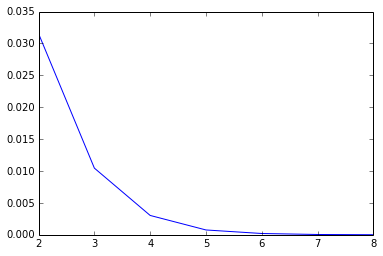

In [16]:
plt.plot(range(2,9), global_errors1)

График ошибки, по абсциссе $log_2 (h_k)$, по ординате -- $log_2 (\frac{err_{k+1}}{err_k})$. Кривая стремится к постоянному уровню, но это явно не порядок метода.

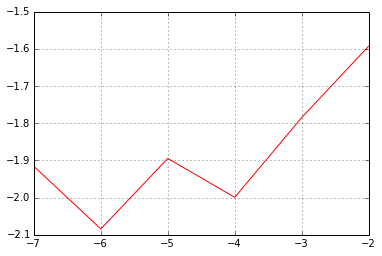

In [17]:
log_h2 = [ log(((b - a) / 2 ** k), 2) for k in range(2,n)]
log_global_error1 = [log(global_errors1[k+1] / global_errors1[k], 2) for k in range(0,n-3)]
plt.plot(log_h2[:(n-3)], log_global_error1, 'r')
plt.grid(True)

Логарифм ошибки, по абсциссе $lg(h_k)$, по ординате -- $lg(err_k)$, но наклон тоже не похож на 3, 0.9 где-то.

In [18]:
lg_h = [ log(((b - a) / 2 ** k)) for k in range(2,n)]
lg_global_error1 = [log(error) for error in global_errors1]

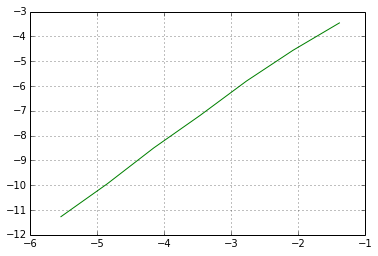

In [19]:
plt.plot(lg_h, lg_global_error1, 'g')
plt.grid(True)

Пытаюсь получить средний наклон.

In [20]:
mean_k = []
for l in range(1, len(lg_h)-1):
    mean_k.append((lg_global_error1 [l]-lg_global_error1[l+1])/(lg_h[l]-lg_h[l+1]))
mean_k = sum(mean_k) / len(mean_k)
print(mean_k)

1.9358271778923228
